In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Voting
## VotingClassifier

Идея `VotingClassifier` состоит в том, чтобы объединить принципиально разные классификаторы машинного обучения и использовать большинство голосов(жесткое голосование) или средние прогнозируемые вероятности (мягкое голосование) для прогнозирования меток классов. 

Такой классификатор может быть полезен для набора одинаково хорошо работающих моделей, чтобы сбалансировать их индивидуальные недостатки.

### Жесткое головование

При жестком голосовании прогнозируемая метка класса для конкретной выборки представляет собой метку класса, которая определяется большинством меток классов, предсказанных каждым отдельным классификатором.

Например, если прогноз для данной выборки:

классификатор 1 -> класс 1\
классификатор 2 -> класс 1\
классификатор 3 -> класс 2

Классификатор VotingClassifier (с голосованием='hard') классифицировал бы выборку как «класс 1» на основе выбора метки большинством моделей.

В случае ничьей, `VotingClassifier` выберет класс на основе сортировки по возрастанию. Например:

классификатор 1 -> класс 2\
классификатор 2 -> класс 1

Образцу будет присвоена метка класса 1.

Accuracy: 0.87 (+/- 0.09) [Logistic Regression]
Accuracy: 0.69 (+/- 0.12) [Random Forest]
Accuracy: 0.76 (+/- 0.09) [naive Bayes]
Accuracy: 0.77 (+/- 0.08) [Voiting]


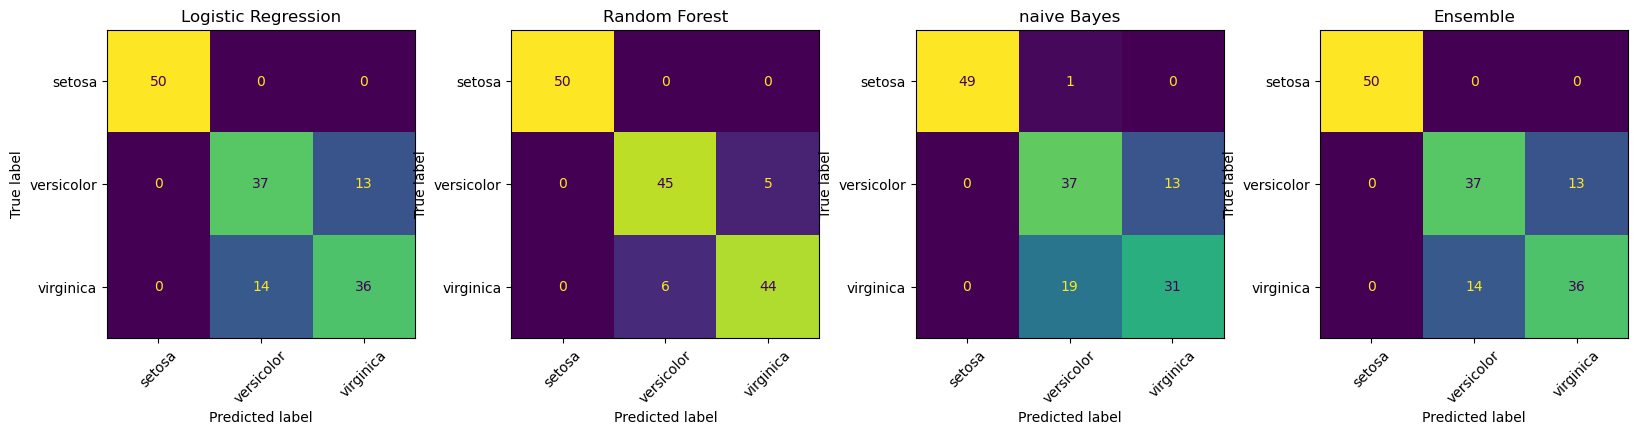

In [2]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X = iris.data[:,[0,1]] 
y = iris.target

clf_v1 = LogisticRegression(max_iter=1000)
clf_v2 = RandomForestClassifier(n_estimators=50)
clf_v3 = GaussianNB()

e_v_clf = VotingClassifier(
    estimators=[('lr', clf_v1), ('rf', clf_v2), ('gnb', clf_v3)],
    voting='hard')

for clf, label in zip([clf_v1, clf_v2, clf_v3, e_v_clf], ['Logistic Regression', 'Random Forest', 
                                                 'naive Bayes', 'Voiting']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=ShuffleSplit(n_splits=5))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

f, axes = plt.subplots(1, 4, figsize=(20, 4))
for i,(clf, label) in enumerate(zip([clf_v1, clf_v2, clf_v3, e_v_clf], ['Logistic Regression', 
                                                               'Random Forest', 'naive Bayes', 'Ensemble'])):
    y_pred = clf.fit(X, y).predict(X) 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred), display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(label)
    disp.im_.colorbar.remove()

    


### Мягкое головование

В отличие от голосования большинством (жесткое голосование), мягкое голосование возвращает метку класса как $argmax$ суммы предсказанных вероятностей.

Каждому классификатору можно присвоить определенные веса с помощью параметра веса. При указании весов прогнозируемые вероятности классов для каждого классификатора собираются, умножаются на вес классификатора и усредняются. Затем окончательная метка класса получается из метки класса с наибольшей средней вероятностью.

Чтобы проиллюстрировать это на простом примере, давайте предположим, что у нас есть 3 классификатора и задачи классификации с 3 классами, где мы присваиваем всем классификаторам равные веса: 

$w_1=1, w_2=1, w_3=1.$

Затем средневзвешенные вероятности для метки выборки будут рассчитываться следующим образом:

|classifier |	class 1 |	class 2	| class 3|
|------|------|------|-------|
|classifier 1 |	w1 * 0.2 |	w1 * 0.5 |	w1 * 0.3|
|classifier 2 |	w2 * 0.6 | 	w2 * 0.3 | w2 * 0.1|
|classifier 3 |	w3 * 0.3 |	w3 * 0.4 |	w3 * 0.3|
|weighted average |	0.37 |	0.4	 | 0.23 |


Здесь предсказанная метка класса равна 2, так как она имеет самую высокую среднюю вероятность.

В следующем примере показано, как области принятия решений могут измениться, когда используется мягкий классификатор голосования на основе линейной машины опорных векторов, дерева решений и классификатора K-ближайших соседей:



Accuracy: 0.81 (+/- 0.06) [DecisionTree]
Accuracy: 0.79 (+/- 0.05) [KNeighbors]
Accuracy: 0.82 (+/- 0.06) [SVC]
Accuracy: 0.81 (+/- 0.06) [Ensemble]


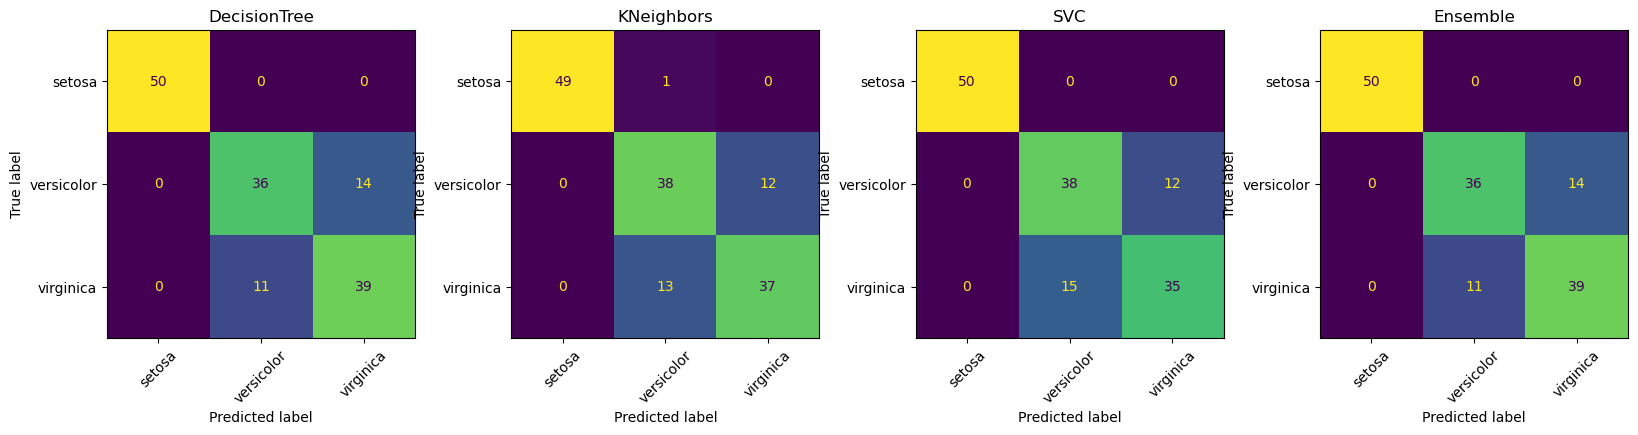

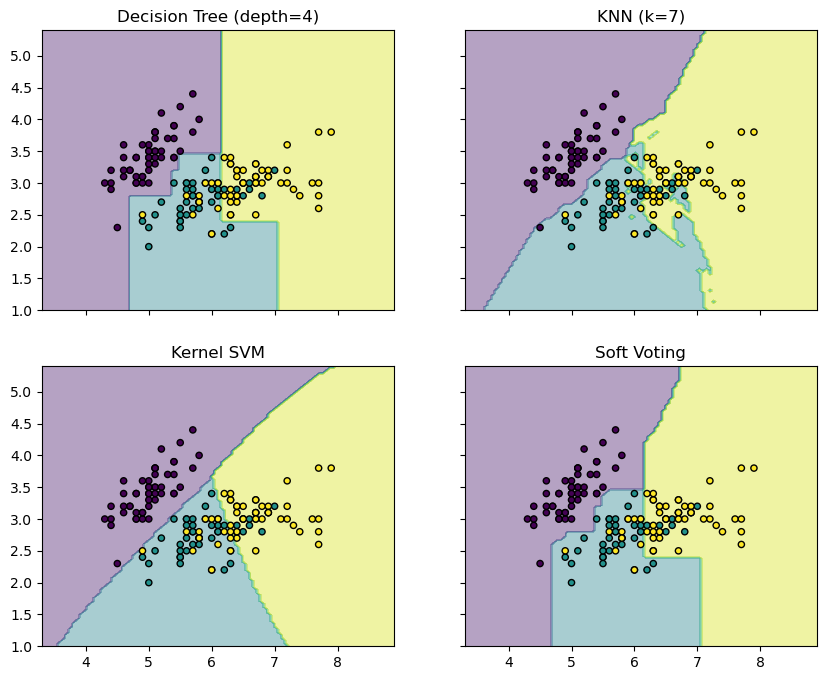

In [3]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay


# Training classifiers
clf_vs1 = DecisionTreeClassifier(max_depth=4)
clf_vs2 = KNeighborsClassifier(n_neighbors=7)
clf_vs3 = SVC(kernel='rbf', probability=True)
e_vs_clf = VotingClassifier(estimators=[('dt', clf_vs1), ('knn', clf_vs2), ('svc', clf_vs3)],
                        voting='soft', weights=[2, 1, 2])

for clf, label in zip([clf_vs1, clf_vs2, clf_vs3, e_vs_clf], ['DecisionTree', 
                                                    'KNeighbors', 'SVC', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


f, axes = plt.subplots(1, 4, figsize=(20, 4))
for i,(clf, label) in enumerate(zip([clf_vs1, clf_vs2, clf_vs3, e_vs_clf], ['DecisionTree', 
                                                               'KNeighbors', 'SVC', 'Ensemble'])):
    y_pred = clf.fit(X, y).predict(X) 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred), display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(label)
    disp.im_.colorbar.remove()


clf_vs1 = clf_vs1.fit(X, y)
clf_vs2 = clf_vs2.fit(X, y)
clf_vs3 = clf_vs3.fit(X, y)
e_vs_clf = e_vs_clf.fit(X, y)

# Plotting decision regions
f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))
for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [clf_vs1, clf_vs2, clf_vs3, e_vs_clf],
    ["Decision Tree (depth=4)", "KNN (k=7)", "Kernel SVM", "Soft Voting"],
):
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx[0], idx[1]], response_method="predict"
    )
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Voting Regressor

Идея `VotingRegressor` заключается в объединении концептуально разных регрессионых моделей машинного обучения и возвращении средних прогнозируемых значений. 

Такой регрессор может быть полезен для набора одинаково хорошо работающих моделей, чтобы уравновесить их индивидуальные недостатки.

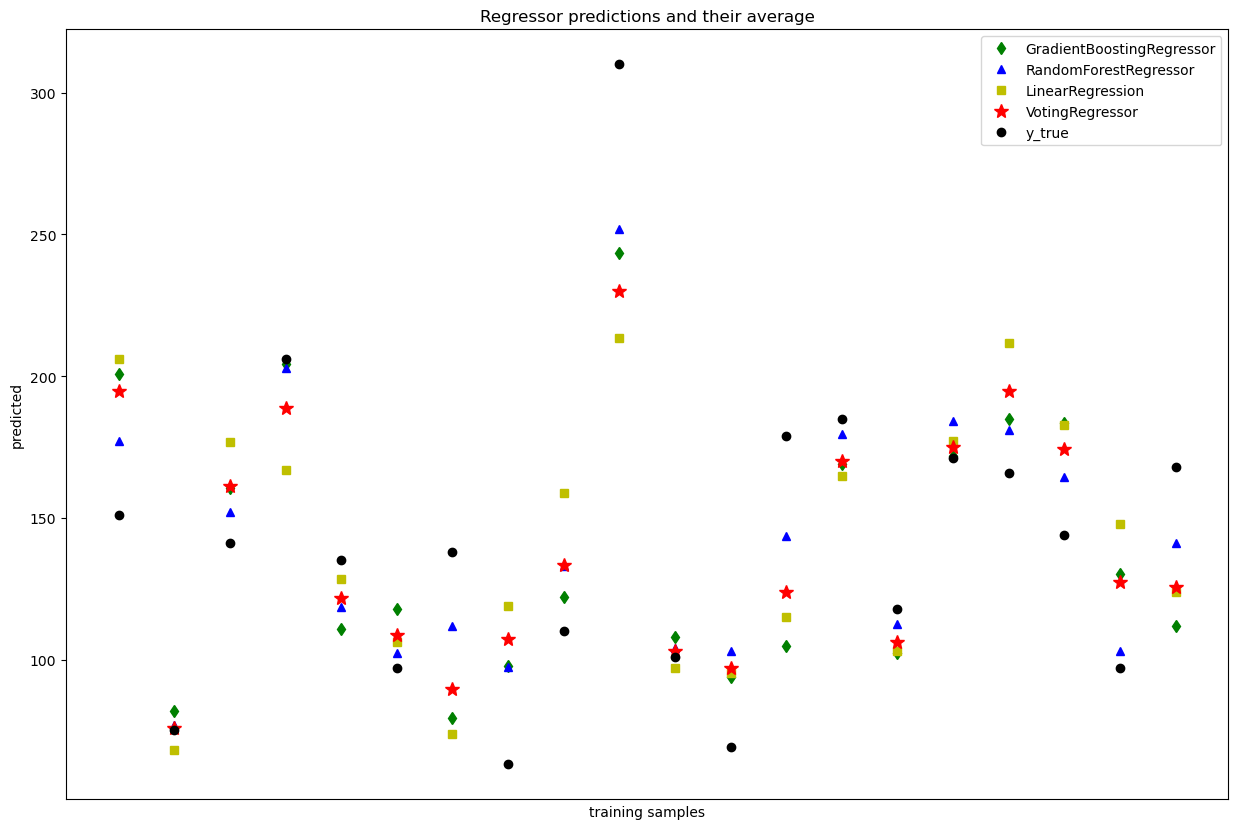

In [4]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

Xd, yd = load_diabetes(return_X_y=True)

# Train classifiers
v_reg1 = GradientBoostingRegressor()
v_reg2 = RandomForestRegressor()
v_reg3 = LinearRegression()

v_reg1.fit(Xd, yd)
v_reg2.fit(Xd, yd)
v_reg3.fit(Xd, yd)

ve_reg = VotingRegressor([("gb", v_reg1), ("rf", v_reg2), ("lr", v_reg3)])
ve_reg.fit(Xd, yd)

# обрезали данные для визуализации
xt = Xd[:20]
v_pred1 = v_reg1.predict(xt)
v_pred2 = v_reg2.predict(xt)
v_pred3 = v_reg3.predict(xt)
v_pred4 = ve_reg.predict(xt)

plt.figure(figsize=(15, 10))
plt.plot(v_pred1, "gd", label="GradientBoostingRegressor")
plt.plot(v_pred2, "b^", label="RandomForestRegressor")
plt.plot(v_pred3, "ys", label="LinearRegression")
plt.plot(v_pred4, "r*", ms=10, label="VotingRegressor")
plt.plot(yd[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

# Stacked generalization¶
Стекинг — это метод объединения оценок для уменьшения их систематической ошибки. Точнее, прогнозы каждого отдельного оценщика сводятся в единую таблицу и используются в качестве входных данных для окончательного эстиматора для вычисления прогноза. Этот эстиматор может вычисляться на основе крос-валидационных решений перидущих эстиматоров.


## StackingClassifier


In [5]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_validate

clf_v1 = LogisticRegression(max_iter=1000)
clf_v2 = RandomForestClassifier(n_estimators=50)
clf_v3 = GaussianNB()

e_s_clf = StackingClassifier(
        estimators = [
            ('lr', clf_v1), 
            ('rf', clf_v2), 
            ('gnb', clf_v3)],
        final_estimator = RandomForestClassifier(n_estimators=50),
        stack_method = 'predict_proba'
)

e_s_clf.fit(X,y)

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('gnb', GaussianNB())],
                   final_estimator=RandomForestClassifier(n_estimators=50),
                   stack_method='predict_proba')

Accuracy: 0.800 (+/- 0.12) [Logistic Regression]
Accuracy: 0.787 (+/- 0.12) [Random Forest]
Accuracy: 0.787 (+/- 0.11) [naive Bayes]
Accuracy: 0.840 (+/- 0.07) [Voiting]
Accuracy: 0.800 (+/- 0.07) [Stacking]


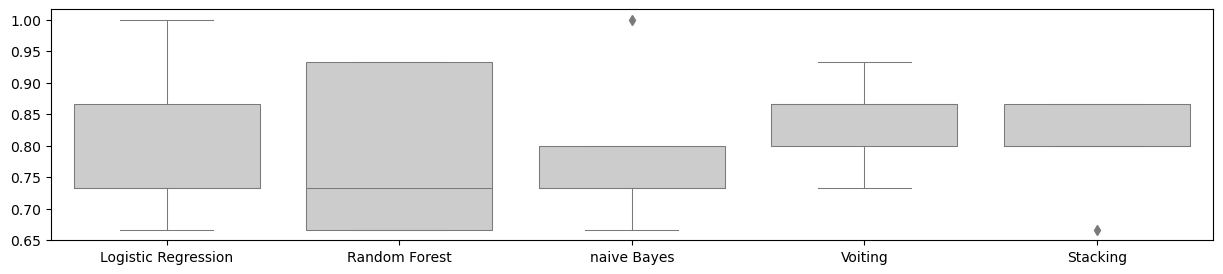

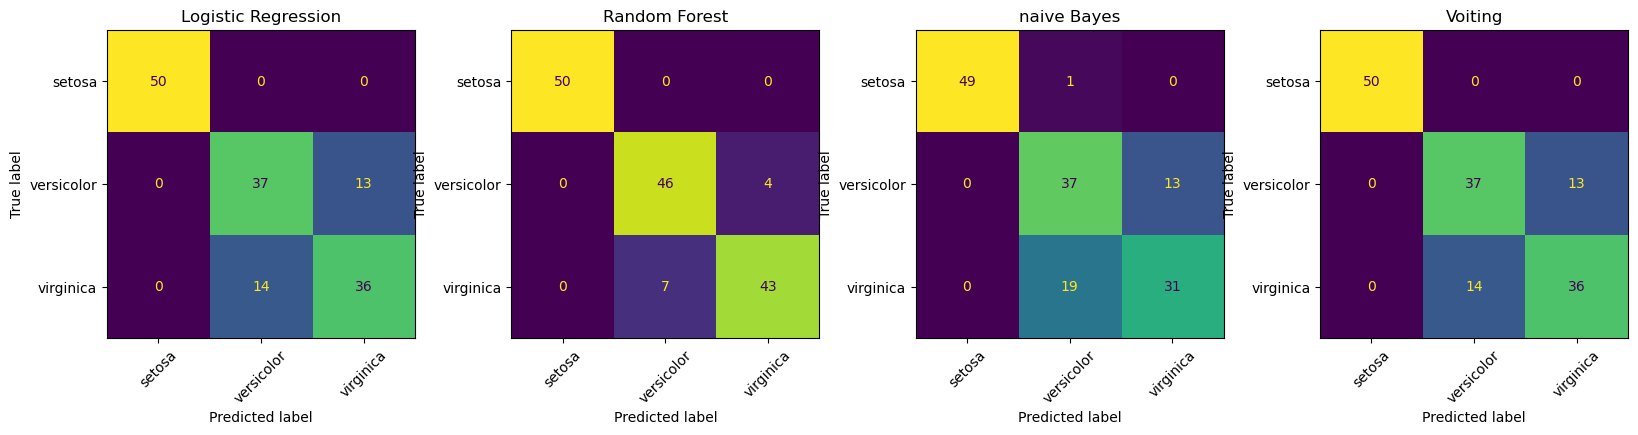

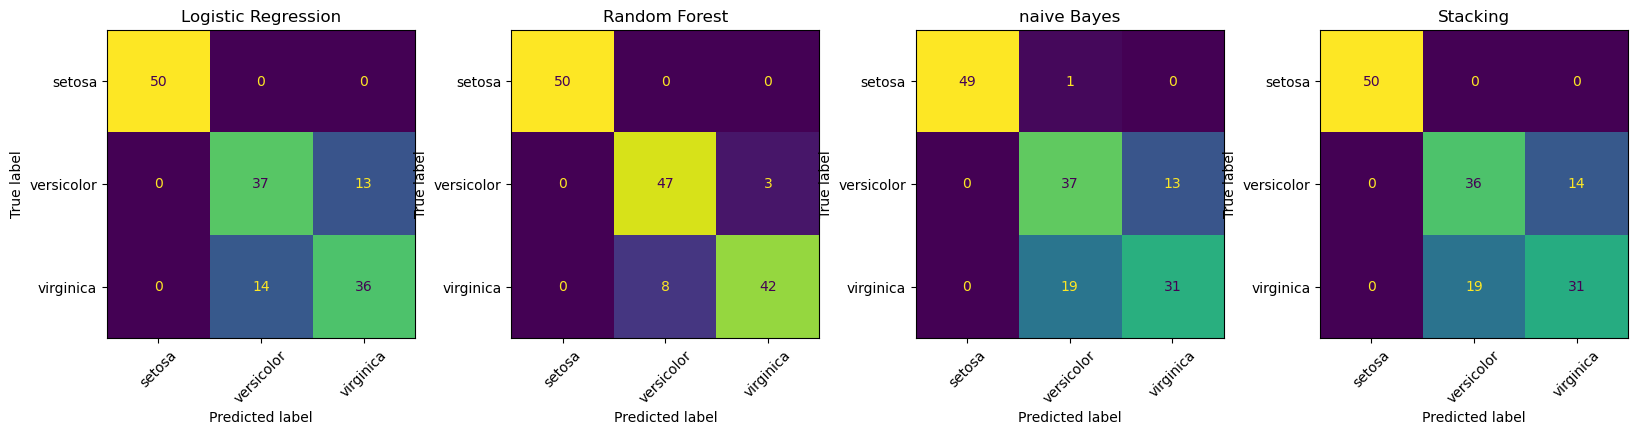

In [6]:
global_scores = []
names_est = ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Voiting','Stacking']
for clf, label in zip([clf_v1, clf_v2, clf_v3, e_v_clf, e_s_clf], names_est):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=ShuffleSplit(n_splits=5))
    global_scores.append(scores)
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
plt.figure(figsize=(15,3))
sns.boxplot(data=pd.DataFrame(np.array(global_scores).T, columns = names_est), color=".8",linewidth=.75);

f, axes = plt.subplots(1, 4, figsize=(20, 4))
for i,(clf, label) in enumerate(zip([clf_v1, clf_v2, clf_v3, e_v_clf], ['Logistic Regression', 
                                                               'Random Forest', 'naive Bayes', 'Voiting'])):
    y_pred = clf.fit(X, y).predict(X) 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred), display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(label)
    disp.im_.colorbar.remove()
    
f, axes = plt.subplots(1, 4, figsize=(20, 4))
for i,(clf, label) in enumerate(zip([clf_v1, clf_v2, clf_v3, e_s_clf], ['Logistic Regression', 
                                                               'Random Forest', 'naive Bayes', 'Stacking'])):
    y_pred = clf.fit(X, y).predict(X) 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred), display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(label)
    disp.im_.colorbar.remove()

## StackingRegressor

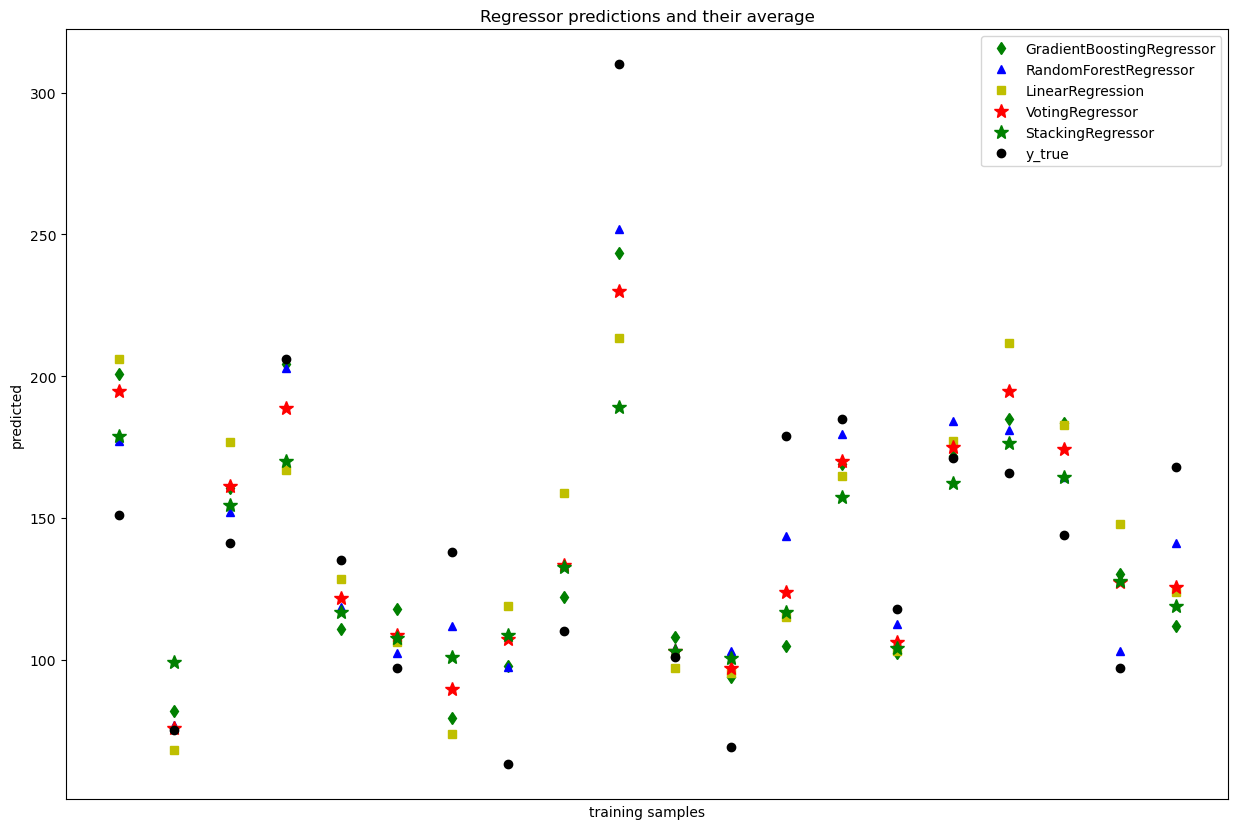

In [7]:
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR


se_reg = StackingRegressor(
    estimators = [("gb", v_reg1), ("rf", v_reg2), ("lr", v_reg3)],
    final_estimator = SVR()
)
se_reg.fit(Xd, yd)

# обрезали данные для визуализации
xt = Xd[:20]

v_pred5 = se_reg.predict(xt)




plt.figure(figsize=(15, 10))
plt.plot(v_pred1, "gd", label="GradientBoostingRegressor")
plt.plot(v_pred2, "b^", label="RandomForestRegressor")
plt.plot(v_pred3, "ys", label="LinearRegression")
plt.plot(v_pred4, "r*", ms=10, label="VotingRegressor")
plt.plot(v_pred5, "g*", ms=10, label="StackingRegressor")
plt.plot(yd[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()